In [3]:
import random
import math
import scipy
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

####################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


####################################
import tensorflow
from tensorflow.keras.models import Sequential, Model,  Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate,  multiply, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, MaxPooling2D, RepeatVector, SpatialDropout1D, SimpleRNN, GRU, Bidirectional, Reshape
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator, pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

####################################
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Functions

In [29]:
class signal_data_maker:
    @staticmethod
    def pad_zeros(x, maxlen, how = 'pre'):
        """
        Дополняет ветор нулями до длины maxlen спереди или сзади.
        """
        x = np.array(x)
        lenx = x.shape[0]
        len0 = maxlen - lenx
        x0 = np.zeros(len0)
        if how == 'pre':
            x = np.concatenate([x0,x])
        elif how == 'after':
            x = np.concatenate([x,x0])
        return x

    @staticmethod
    def get_corr_coef(data, back_steps): #  шаг смещения >= 0
        """
        Calculate correlation coefficient
        :param data: numpy 1D array
        :param back_steps:  autocorrelation shift
        :return: correlation coefficient, float
        """

        return np.corrcoef(data[back_steps:], data[:len(data) - back_steps])[0, 1]

    @staticmethod
    def make_random_signal(length, ma):
        """
        The function creates a smooth signal obtained from noise.

        """

        x = np.random.normal(0,1,max(length*2, ma * 2))
        x = pd.Series(x).rolling(window = ma).mean().dropna().values
        x = x[:length]
        abs_x = np.abs(x)

        max_value =abs_x.max()
        x = x/max_value
        return x

    @staticmethod
    def calculate_hulving_time_acf(y, treshold_acf = 0.5):
        """
        Receive autocorrelation function and return the time it takes to halve
        """
        if y[0] != 1:
            raise ValueError("Начальное значение автокорреляционной функции не равно 1")

        for i in range(y.shape[0]):
            if y[i] <= treshold_acf:
                break
        t2 = i
        t1 = i-1
        y1 = y[t1]
        y2 = y[t2]
        k = (t1 - t2) / (y1 - y2)
        b = t2 - k*y2
        t = k * 0.5 + b
        return t

    @classmethod
    def make_autocorrelation_dependence(cls,x, treshold_acf = 0.5):
        """
        It takes a numpy array, and the maximum number of steps to calculate the autocorrelation function. The number of steps is expressed in terms of a fraction of the window (the length of the received signal).
        :param x: numpy 1D array
        :param steps_max_part_window: fraction of the array window, default 0.5
        :return: numpy array
        """
        corr = 1
        coefs = [corr]
        steps = 1
        while corr >= treshold_acf:
            corr = cls.get_corr_coef(x, steps)
            steps += 1
            coefs.append(corr)
        return np.array(coefs)

    @classmethod
    def make_abs_spectr(cls,signal, normalise_rfft = True, padd_signal_len = None):
        """
        Function receive numpy array signal, calculate abs FFT.
        If you want you may normalise it, as default
        """
        if padd_signal_len:
            signal = cls.pad_zeros(signal, padd_signal_len)
        signal_fft = np.abs(rfft(signal))
        if normalise_rfft:
            signal_fft = signal_fft / signal_fft.max()
        signal_fft = np.array(signal_fft)
        return signal_fft

    @classmethod
    def make_gauss_bands(cls,hulvings, window_band, wide = 2):
        lower_band = []
        upper_band = []
        center = []
        x_stats = np.array(range(window_band, hulvings.shape[0]))
        for i in x_stats:
            row = hulvings[i-window_band:i]
            std = row.std()
            lower_band.append(row.mean() - wide * std)
            upper_band.append(row.mean() + wide * std)
            center.append(row.mean())
        return np.array(center), np.array(lower_band), np.array(upper_band), x_stats

    @classmethod
    def make_halving_treshold(сls, hulvings, window, delta_percent = 0):
        """
        Максимальное и минимальное знанчение являются пороговыми. Настраиваемый параметр - window - за какой период мы берем его.

        :param hulvings: numpy array
        :param window: Which wondow used to calculate halving
        :return: Turple od 2 numpy arrayus (lower_band, upper_band)
        """
        lower_band = []
        upper_band = []
        center = []
        x_stats = np.array(range(window, hulvings.shape[0]))
        for i in x_stats:
            row = hulvings[i-window:i]
            lower_band.append(row.min() - row.min() * delta_percent)
            upper_band.append(row.max() + row.max() * delta_percent)
            center.append((row.max() + row.min())/2)
        return np.array(center), np.array(lower_band), np.array(upper_band), x_stats

    @classmethod
    def find_halving_treshold_moments(cls,center, lower_band, upper_band, window, hulvings):
        """
        ? Speed changing
        ? Density of moments

        Function finds time moments, when time hulving begin too much different, then earlier/
        The strategy is to look for the moment when the halving timeline of the autocorrelation function touches the upper or lower threshold. This will be the time when a new signal is detected. So that it does not signal constantly, the cancellation will be the touch of the central average from the two thresholds.
        :param center: mean (upper-lower) band, numpy array
        :param lower_band: upper treshold, numpy array
        :param upper_band: lower treshold, numpy array
        :param window: window, whisch used to calculcate hulving time, int
        :param hulvings: hulvings array,  numpy array
        :return: numpy array with time indices
        """
        results = []
        flag = 0     # При активном флаге мы отмечаем
        for i in range(window, hulvings.shape[0]):
            if not flag:
                if hulvings[i] > upper_band[i-window]:
                    flag = 1
                    results.append(i)
                if hulvings[i] < lower_band[i-window]:
                    flag = -1
                    results.append(i)
            if flag == 1:
                if hulvings[i] <= center[i - window]:
                    flag = 0
            if flag == -1:
                if hulvings[i] >= center[i - window]:
                    flag = 0
        results = np.array(results)
        return results

    @classmethod
    def halving_treshold_stats(cls, hulving_moments, window, length1, length2):
        """
        Return a dictionry, which contains wrong and true number of detectings, momemts of detecting new signal
        :param hulving_moments: Numpy array of time inexes of hulvings
        :param window: window, which used to create hulving, observed window
        :param length1: Size of the first signal
        :param length2: Size of the second signal
        :return: Dictionary with statistics and information
        """
        stats = {'wrong': 0, 'is_detected': False,  'window' : window, 'time_detecting': None}
        t1 = length1 - window
        for i in hulving_moments:
            if i < t1 :
                stats['wrong'] += 1
            else:
                stats['is_detected'] = True
                time_detected = i - t1
                stats['time_detecting'] = time_detected
                break

        return stats

    def __init__(self, observe_window_lower = 10, observe_window_upper = 300, mooving_average_window_lower = 10, mooving_average_window_upper = 200):
        self.observe_window_lower = observe_window_lower
        self.observe_window_upper = observe_window_upper
        self.mooving_average_window_lower = mooving_average_window_lower
        self.mooving_average_window_upper = mooving_average_window_upper

    def make_window_ma(self):
        """
        Генерация размера скользящего окна, диапазоны указываем в аргументах
        """
        return random.randint(self.mooving_average_window_lower, self.mooving_average_window_upper)

    def make_observing_window(self):
        """
        Генерация окна наблюдения. То окно, которое будем использовать для обнаружения нестационарности.
        """
        return random.randint(self.mooving_average_window_lower, self.mooving_average_window_upper)

    def make_exaple_2_signals_acf(self, observe_vindow = None, ma1_window = None, ma2_window = None, delta_percent_treshold = 0.03, plot_data = True):
        if not observe_vindow:
            observe_vindow = self.make_observing_window()

        if not ma1_window:
            ma1_window = self.make_window_ma()

        if not ma2_window:
            ma2_window = self.make_window_ma()
            while ma1_window == ma2_window:
                ma2_window = self.make_window_ma()

        length1 = observe_vindow * 6
        length2 = observe_vindow * 6
        signal1 = self.make_random_signal(length1, ma1_window)
        signal2 = self.make_random_signal(length2, ma2_window)
        signal = np.concatenate([signal1, signal2])

        signal_chunks = [signal[i:i+observe_vindow] for i in range(signal.shape[0]-observe_vindow-1)]
        acf_chunks = [self.make_autocorrelation_dependence(i) for i in signal_chunks]
        hulvings = [self.calculate_hulving_time_acf(i) for i in acf_chunks]
        center, lower_band, upper_band, x_stats = self.make_halving_treshold(np.array(hulvings), window = observe_vindow, delta_percent= delta_percent_treshold)
        hulving_moments = self.find_halving_treshold_moments(center, lower_band, upper_band, observe_vindow, np.array(hulvings))
        result_stats = self.halving_treshold_stats(hulving_moments, observe_vindow, length1, length2)
        x_stats_hulv = np.arange(len(hulvings))
        if plot_data:
            fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(15,10)) # параметры shareх и sharey - если False, то у каждого графика
            ax[0].plot(x_stats +  observe_vindow, upper_band, linewidth= 1, color = 'g',  label = 'upper', alpha=0.5)
            ax[0].plot(x_stats +  observe_vindow, lower_band, linewidth= 1, color = 'g', label = 'lower', alpha=0.5)
            ax[0].plot(x_stats  +  observe_vindow, center, linewidth= 1, color = 'y',  label = 'center', alpha=0.5)
            ax[0].plot(x_stats_hulv  +  observe_vindow, hulvings, label = 'hulvings', linewidth= 1)
            ax[0].axvline(x=signal1.shape[0], color = 'r', linewidth= 1, alpha=0.5)
            ax[0].axvline(x=signal1.shape[0] + observe_vindow, color = 'r', ls = '--', linewidth= 1, alpha=0.5)
            ax[0].set_xlim([0, signal.shape[0]])
            #plt.title("Время халвинга автокорреляционной функции")
            #plt.xlim([0, signal.shape[0]])
            ax[1].plot(signal, linewidth= 1)
            ax[1].axvline(x=signal1.shape[0], color = 'r', linewidth= 1, alpha=0.5)
            ax[1].axvline(x=signal1.shape[0] + observe_vindow, color = 'r', ls = '--', linewidth= 1, alpha=0.5)
            ax[1].set_xlim([0, signal.shape[0]])
            #plt.title("График сшивки двух сигналов")
            plt.show()
        return result_stats

class nn_data_maker(signal_data_maker):
    @classmethod
    def make_abs_spectr(cls,signal, normalise_rfft = True, padd_signal_len = None):
        """
        Function receive numpy array signal, calculate abs FFT.
        If you want you may normalise it, as default
        """
        if padd_signal_len:
            signal = cls.pad_zeros(signal, padd_signal_len)
        signal_fft = np.abs(rfft(signal))
        if normalise_rfft:
            signal_fft = signal_fft / signal_fft.max()
        signal_fft = np.array(signal_fft)
        return signal_fft

    def __init__(self, part_window_of_new_signal = np.linspace(0.05, 0.4, 20), observe_window_lower = 10, observe_window_upper = 300, mooving_average_window_lower = 10, mooving_average_window_upper = 200):
        self.part_window_of_new_signal = part_window_of_new_signal
        self.observe_window_lower = observe_window_lower
        self.observe_window_upper = observe_window_upper
        self.mooving_average_window_lower = mooving_average_window_lower
        self.mooving_average_window_upper = mooving_average_window_upper

    def make_new_window_part(self):
        """
        Генерация размера скользящего окна, диапазоны указываем в аргументах
        """
        return random.choice(self.part_window_of_new_signal)

    def make_simple_data_signal(self, N):
        """
        Создание обучающего датасета. Часть датасета является одним сигналом, часть - сшивка двух сигналов.
        """

        # First signal
        X = []
        y = []
        for i in range(int(N/2)):
            ma = self.make_window_ma()
            window = self.make_observing_window()
            signal = self.make_random_signal(window, ma)
            X.append(signal.tolist())
            y.append(0)

        #2 signals
        for i in range(int(N/2)):
            ma1 = self.make_window_ma()
            ma2 = self.make_window_ma()
            while ma1 == ma2:
                ma2 = self.make_window_ma()

            window = self.make_observing_window()
            signal1 = self.make_random_signal(window, ma1)
            signal2 = self.make_random_signal(window, ma2)
            new_window_part = self.make_new_window_part()
            t2 = int(new_window_part * window)
            t1 = window - t2
            signal = np.concatenate([signal1[:t1], signal2[:t2]])
            X.append(signal.tolist())
            y.append(1)


        X = pad_sequences(X, dtype='float', maxlen=self.observe_window_upper)

        # shuffle data
        X = pd.DataFrame(X)
        X['y'] = y
        X = X.sample(frac=1)
        X = X.sample(frac=1)

        y = X.y.values
        X = X.drop('y', axis=1).values

        y = to_categorical(y)

        return X, y


    def make_datas_2_parts_of_signal(self, N, windows_treshold = 0.7):
        """
        Создание обучающего датасета. Часть датасета является одним сигналом, часть - сшивка двух сигналов.
        """

        # First signal
        left_part_of_signal = []
        right_part_of_signal = []
        y = []
        for i in range(int(N/2)):
            ma = self.make_window_ma()
            window = self.make_observing_window()
            signal = self.make_random_signal(window, ma)

            # Раскидываем сигналы внутри окна по половинкам
            t1 = int(window * windows_treshold)
            left_part_of_signal.append(signal[:t1])
            right_part_of_signal.append(signal[t1:])
            y.append(0)

        #Second signal
        for i in range(int(N/2)):
            ma1 = self.make_window_ma()
            ma2 = self.make_window_ma()
            while ma1 == ma2:
                ma2 = self.make_window_ma()

            window = self.make_observing_window()
            signal1 = self.make_random_signal(window, ma1)
            signal2 = self.make_random_signal(window, ma2)
            new_window_part = self.make_new_window_part()
            t2 = int(new_window_part * window)
            t1 = window - t2
            signal = np.concatenate([signal1[:t1], signal2[:t2]])

            # Раскидываем сигналы внутри окна по половинкам
            t1 = int(window * windows_treshold)
            left_part_of_signal.append(signal[:t1])
            right_part_of_signal.append(signal[t1:])
            y.append(1)

        left_part_of_signal = pad_sequences(left_part_of_signal, dtype='float',
                                            maxlen=round(self.observe_window_upper * windows_treshold) + 1 )
        right_part_of_signal = pad_sequences(right_part_of_signal, dtype='float',
                                             maxlen=round(self.observe_window_upper * (1 - windows_treshold)) + 1 )

        left_shape = left_part_of_signal.shape

        # shuffle data
        X = np.concatenate([left_part_of_signal, right_part_of_signal], axis=1)
        X = pd.DataFrame(X)
        X['y'] = y
        X = X.sample(frac=1)
        X = X.sample(frac=1)

        y = X.y.values
        X = X.drop('y', axis=1).values

        y = to_categorical(y)

        X1 = X[:, :left_shape[1]]
        X2 = X[:, left_shape[1]:]

        return X1, X2, y

    def make_2_spectr_data(self, N, windows_treshold = 0.5, return_one_df = True):
        # First signal
        left_part_of_signal = []
        right_part_of_signal = []
        y = []
        for i in range(int(N/2)):
            ma = self.make_window_ma()
            window = self.make_observing_window()
            signal = self.make_random_signal(window, ma)

            # Раскидываем сигналы внутри окна по половинкам
            t1 = int(window * windows_treshold)
            left_part_of_signal.append(signal[:t1])
            right_part_of_signal.append(signal[t1:])
            y.append(0)

        #Second signal
        for i in range(int(N/2)):
            ma1 = self.make_window_ma()
            ma2 = self.make_window_ma()
            while ma1 == ma2:
                ma2 = self.make_window_ma()

            window = self.make_observing_window()
            signal1 = self.make_random_signal(window, ma1)
            signal2 = self.make_random_signal(window, ma2)
            new_window_part = self.make_new_window_part()
            t2 = int(new_window_part * window)
            t1 = window - t2
            signal = np.concatenate([signal1[:t1], signal2[:t2]])

            # Раскидываем сигналы внутри окна по половинкам
            t1 = int(window * windows_treshold)
            left_part_of_signal.append(signal[:t1])
            right_part_of_signal.append(signal[t1:])
            y.append(1)

        left_part_of_signal = pad_sequences(left_part_of_signal, dtype='float',
                                            maxlen=round(self.observe_window_upper * windows_treshold) + 1 ).tolist()
        right_part_of_signal = pad_sequences(right_part_of_signal, dtype='float',
                                             maxlen=round(self.observe_window_upper * (1 - windows_treshold)) + 1 ).tolist()

        #Calculate Spectrum
        left_part_of_signal = [self.make_abs_spectr(i) for i in left_part_of_signal]
        right_part_of_signal = [self.make_abs_spectr(i) for i in right_part_of_signal]
        left_part_of_signal = np.array(left_part_of_signal)
        right_part_of_signal = np.array(right_part_of_signal)
        left_shape = left_part_of_signal.shape

        # shuffle data
        X = np.concatenate([left_part_of_signal, right_part_of_signal], axis=1)
        X = pd.DataFrame(X)
        X['y'] = y
        X = X.sample(frac=1)
        X = X.sample(frac=1)

        #Prepare to return
        y = X.y.values
        X = X.drop('y', axis=1).values

        y = to_categorical(y)

        if return_one_df:
            return X, y
        else:
            X1 = X[:, :left_shape[1]]
            X2 = X[:, left_shape[1]:]
            return X1, X2, y

class train_nn:
    def __init__(self, model, optimizer = Adam(learning_rate = 1e-3), loss = 'categorical_crossentropy', metrics = ['accuracy']):

        self.model = model
        self.optimizer = optimizer
        self.loss = loss
        self.metrics = metrics
        self.model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
        self.model.summary()

    def fit(self, X_train,  y_train, X_test, y_test, epochs = 15 , batch_size = 32 ,  verbose = True, use_callbacks = True):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.epochs = epochs
        self.batch_size = batch_size
        if use_callbacks:
            self.history = self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size,
                        validation_data=(self.X_test, self.y_test), verbose = verbose,
                        callbacks = [EarlyStopping(monitor='val_loss', patience=12, mode = 'min', verbose=0),
                                     ModelCheckpoint(filepath="best_model.hdf5", monitor='val_loss' , save_best_only = True, mode = 'min', verbose = 0),
                                     ReduceLROnPlateau(monitor='val_loss' , mode = 'min', factor=0.5, patience=7, verbose = 0)]
                        )
        else:
            self.history = self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size,
                        validation_data=(self.X_test, self.y_test), verbose = verbose)

    def plot_history(self):
        f, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
        axes[0].plot(self.history.history['loss'], label='Ошибка на обучающем наборе')
        axes[0].plot(self.history.history['val_loss'], label='Ошибка на проверочном наборе')
        axes[0].set_xlabel('Эпоха')
        axes[0].set_ylabel('Ошибка')
        axes[0].legend()

        axes[1].plot(self.history.history['accuracy'], label='Точность на обучающем наборе')
        axes[1].plot(self.history.history['val_accuracy'], label='Точность на проверочном наборе')
        axes[1].set_xlabel('Эпоха')
        axes[1].set_ylabel('Точность')
        axes[1].legend()

    def print_stat_report(self):
        print('Тестовые данные')
        y_pred = np.argmax(self.model.predict(self.X_test), axis=1)
        print(classification_report(np.argmax(self.y_test, axis=1), y_pred))
        print('Тренировочные данные')
        y_pred = np.argmax(self.model.predict(self.X_train), axis=1)
        print(classification_report(np.argmax(self.y_train, axis=1), y_pred))

class check_model(nn_data_maker):
    def __init__(self, model,  part_window_of_new_signal = np.linspace(0.05, 0.5, 20), observe_window_lower = 10, observe_window_upper = 300, mooving_average_window_lower = 10, mooving_average_window_upper = 200):
        self.part_window_of_new_signal = part_window_of_new_signal
        self.observe_window_lower = observe_window_lower
        self.observe_window_upper = observe_window_upper
        self.mooving_average_window_lower = mooving_average_window_lower
        self.mooving_average_window_upper = mooving_average_window_upper
        self.model = model

    def make_simple_data_for_check(self, N):
        """
        Создание обучающего датасета. Часть датасета является одним сигналом, часть - сшивка двух сигналов.
        """

        # First signal
        X = []
        y = []
        features = {'ma1' : [], 'ma2':[], 'observed_window':[], 'part_new_signal': []}
        for i in range(int(N/2)):
            ma = self.make_window_ma()
            window = self.make_observing_window()
            signal = self.make_random_signal(window, ma)
            X.append(signal.tolist())
            y.append(0)
            features['ma1'].append(ma)
            features['ma2'].append(ma)
            features['observed_window'].append(window)
            features['part_new_signal'].append(0)

        #2 signals
        for i in range(int(N/2)):
            ma1 = self.make_window_ma()
            ma2 = self.make_window_ma()
            while ma1 == ma2:
                ma2 = self.make_window_ma()

            window = self.make_observing_window()
            signal1 = self.make_random_signal(window, ma1)
            signal2 = self.make_random_signal(window, ma2)
            new_window_part = self.make_new_window_part()
            t2 = int(new_window_part * window)
            t1 = window - t2
            signal = np.concatenate([signal1[:t1], signal2[:t2]])
            X.append(signal.tolist())
            y.append(1)
            features['ma1'].append(ma1)
            features['ma2'].append(ma2)
            features['observed_window'].append(window)
            features['part_new_signal'].append(new_window_part)


        X = pad_sequences(X, dtype='float', maxlen=self.observe_window_upper)
        y = np.array(y)
        y = to_categorical(y)

        self.X = X
        self.y = y
        self.features = features

    @staticmethod
    def ranking(x, N):
        xmin = x.min()
        xmax = x.max()
        rangs = np.linspace(xmin, xmax, N+1)
        for i, r in enumerate(rangs):
            if  i == rangs.shape[0]-1:
                break
            for j, el in enumerate(x):
                if rangs[i] <= el < rangs [i+1]:
                    x[j] = r
        for j, el in enumerate(x):
            if rangs[-1] == el:
                x[j] = r
        return x

    def calculate_statistics(self):
        ########################################
        pred = self.model.predict(self.X)
        pred_0 = pred[:,0]
        pred_1 = pred[:,1]
        pred = np.argmax(pred, axis=1)
        y = np.argmax(self.y, axis=1)
        trues = pred == y
        trues = trues.astype('int32')
        df = pd.DataFrame({'ma1' : self.features['ma1'], 'ma2':self.features['ma2'], 'observed_window':self.features['observed_window'], 'part_new_signal': self.features['part_new_signal'], 'true_predict': trues})   # , 'pred_0': pred_0, 'pred_1': pred_1
        ########################################

        df['max_ma'] = df.loc[:, ['ma1', 'ma2']].max(axis=1)
        df['min_ma'] = df.loc[:, ['ma1', 'ma2']].min(axis=1)
        df['min_max_ma'] = df.min_ma / df.max_ma
        df['max_ma_window'] = df.max_ma / df.observed_window
        ########################################################
        #### Доля правильных ответов в зависимости от максимального окна сглаживания

        #df1 = df.groupby('max_ma', as_index=False).true_predict.mean()
        #plt.plot(df1.max_ma, df1.true_predict)

        ############################################
        #### Доля правильных ответов в зависимости от соотношения сглаживаний
        # ind_min_max = list(df.columns).index('min_max_ma')
        # df.iloc[:, ind_min_max] = self.ranking(df.min_max_ma.values.flatten(), 10)
        # df1 = df.groupby('min_max_ma', as_index=False).true_predict.mean()
        # plt.scatter(df1.min_max_ma.values[:-1], df1.true_predict.values[:-1])
        # plt.title('Доля верных предсказаний в зависимости от отношения размеров окон сглаживаний')
        # plt.xlabel('Отношение размеров окон сглаживаний')
        # plt.ylabel('Доля верных предсказаний')
        # plt.show()
        ############################################
        # Доля правильных ответов в зависимости от соотношения максимального сглаживания и окна
        # ind_max_ma_window = list(df.columns).index('max_ma_window')
        # df.iloc[:, ind_max_ma_window] = self.ranking(df.max_ma_window.values.flatten(), 10)
        # df1 = df.groupby('max_ma_window', as_index=False).true_predict.mean()
        # plt.title('Доля верных предсказаний в зависимости от отношения длины окна сглаживания и следящего окна')
        # plt.scatter(df1.max_ma_window.values[:-1], df1.true_predict.values[:-1])
        # plt.xlabel('Отношение длины окна сглаживания и следящего окна')
        # plt.ylabel('Доля верных предсказаний')
        # plt.show()

        ############################################

        # Доля правильных ответов в зависимости от соотношения максимального сглаживания и окна
        # ind_part_new_signal = list(df.columns).index('part_new_signal')
        # df.iloc[:, ind_part_new_signal] = self.ranking(df.part_new_signal.values.flatten(), 10)
        df1 = df.groupby('part_new_signal', as_index=False).true_predict.mean()
        plt.title('Доля верных предсказаний в зависимости от времени обнаружения нового сигнала')
        plt.scatter(df1.part_new_signal.values[1:], df1.true_predict.values[1:])
        plt.xlabel('Время обнаружения нового сигнала')
        plt.ylabel('Доля верных предсказаний')
        plt.show()

    def visualising(self, ma1 = 10, ma2 = 100, observe_window = 280):
        length1 = observe_window * 4
        length2 = observe_window * 4
        signal1 = self.make_random_signal(length1, ma1)
        signal2 = self.make_random_signal(length2, ma2)
        signal = np.concatenate([signal1, signal2])
        signal_chunks = [signal[i:i+observe_window] for i in range(signal.shape[0]-observe_window-1)]
        acf_chunks = [self.make_autocorrelation_dependence(i) for i in signal_chunks]
        hulvings = [self.calculate_hulving_time_acf(i) for i in acf_chunks]
        center, lower_band, upper_band, x_stats = self.make_halving_treshold(np.array(hulvings), window = observe_window, delta_percent=0.03)
        hulving_moments = self.find_halving_treshold_moments(center, lower_band, upper_band, observe_window, np.array(hulvings))
        #self.halving_treshold_stats(hulving_moments, observe_window, length1, length2)

        ############################
        X = pad_sequences(signal_chunks, dtype='float',
                                            maxlen=300 )
        pred = np.argmax(self.model.predict(X), axis=1)
        plt.plot(pred)
        plt.show()


        plt.figure(figsize = (12,6))

        plt.plot(x_stats, upper_band, linewidth= 1, color = 'r',  label = 'upper', alpha=0.3)
        plt.plot(x_stats, lower_band, linewidth= 1, color = 'r', label = 'lower', alpha=0.3)
        plt.plot(x_stats, center, linewidth= 1, color = 'g',  label = 'center', alpha=0.3)
        plt.plot(hulvings, label = 'hulvings')
        plt.axvline(x=signal1.shape[0]-observe_window)
        plt.axvline(x=signal1.shape[0])
        plt.title("Время халвинга автокорреляционной функции")
        plt.show()
        plt.figure(figsize = (12,6))
        plt.plot(signal)
        plt.axvline(x=signal1.shape[0], color = 'r')
        plt.title("График сшивки двух сигналов")
        plt.show()

62/62 [==============================] - 0s 5ms/step


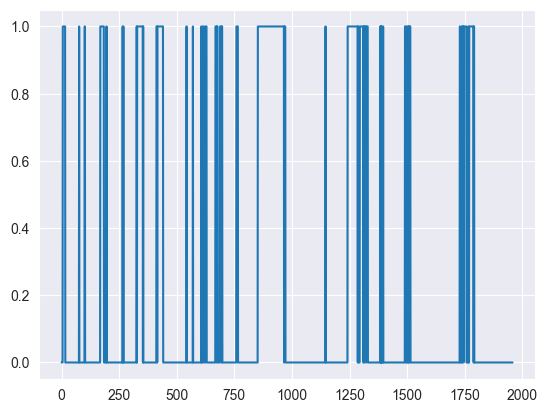

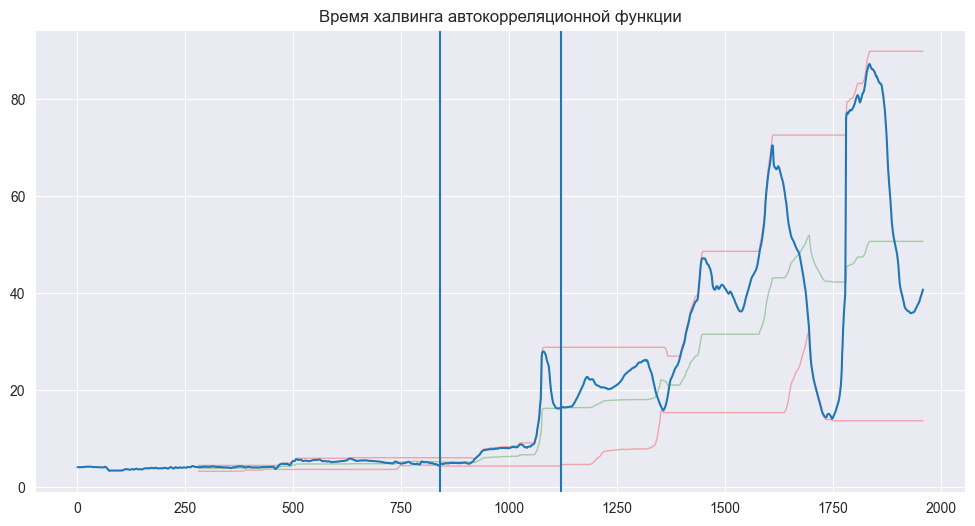

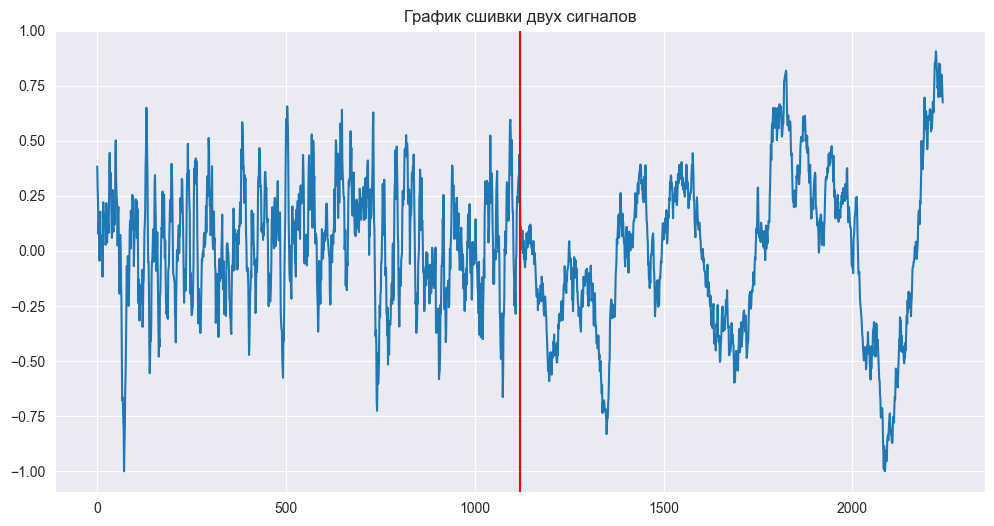

In [30]:
def model_simple_conv1d():
    input = Input(X_train.shape[1])
    x = Reshape((X_train.shape[1],1))(input)

    # Два слоя одномерной свертки Conv1D
    x = Conv1D(30, 3, activation='relu', padding='same')(x)
    x = Conv1D(30, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(60, 3, activation='relu', padding='same')(x)
    x = Conv1D(60, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)

    #x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(400, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input,x)

    #model.summary()
    return model


model = model_simple_conv1d()
model.load_weights('model_simple_conv1d.hdf5')
test = check_model(model)
test.visualising()

# Check model

3125/3125 [==============================] - 5s 1ms/step


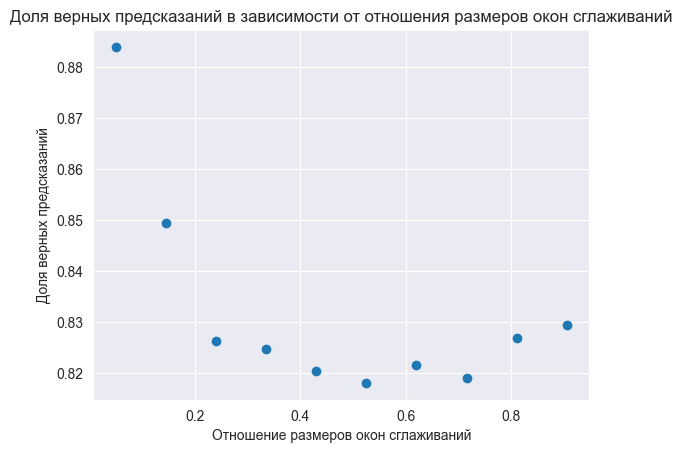

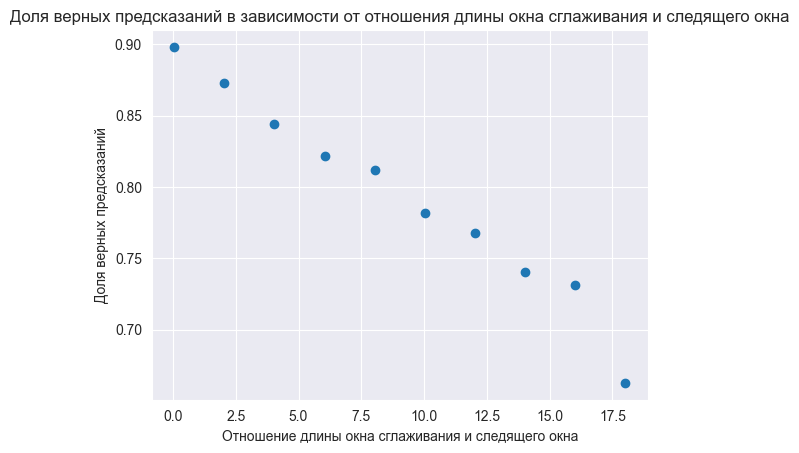

In [17]:
def model_simple_conv1d():
    input = Input(X_train.shape[1])
    x = Reshape((X_train.shape[1],1))(input)

    # Два слоя одномерной свертки Conv1D
    x = Conv1D(30, 3, activation='relu', padding='same')(x)
    x = Conv1D(30, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(60, 3, activation='relu', padding='same')(x)
    x = Conv1D(60, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)

    #x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(400, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input,x)

    #model.summary()
    return model


model = model_simple_conv1d()
model.load_weights('model_simple_conv1d.hdf5')
stats = check_model(model = model)
stats.make_simple_data_for_check(100000)
stats.calculate_statistics()

# Simple data

In [6]:
X_train,y_train = nn_data_maker().make_simple_data_signal(100)
X_test,y_test = nn_data_maker().make_simple_data_signal(100)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100, 300)
(100, 2)
(100, 300)
(100, 2)


In [ ]:
def dense1():
    input1 = Input(X_train.shape[1])
    l = Dense(256, activation="relu")(input1)
    l = Dropout(0.25)(l)
    l = Dense(128, activation="relu")(input1)
    l = Dropout(0.25)(l)
    #l = BatchNormalization()(l)
    l = Dense(2, activation = 'softmax')(l)
    model = Model(input1, l)
    return model

trainer = train_nn(dense1() , optimizer = Adam(learning_rate = 1e-3))
trainer.fit(X_train,  y_train, X_test, y_test, batch_size = 64, epochs=300)
trainer.plot_history()
trainer.print_stat_report()

# Conv1d

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 reshape (Reshape)           (None, 300, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 300, 30)           120       
                                                                 
 conv1d_1 (Conv1D)           (None, 298, 30)           2730      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 149, 30)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 149, 60)           5460      
                                                             

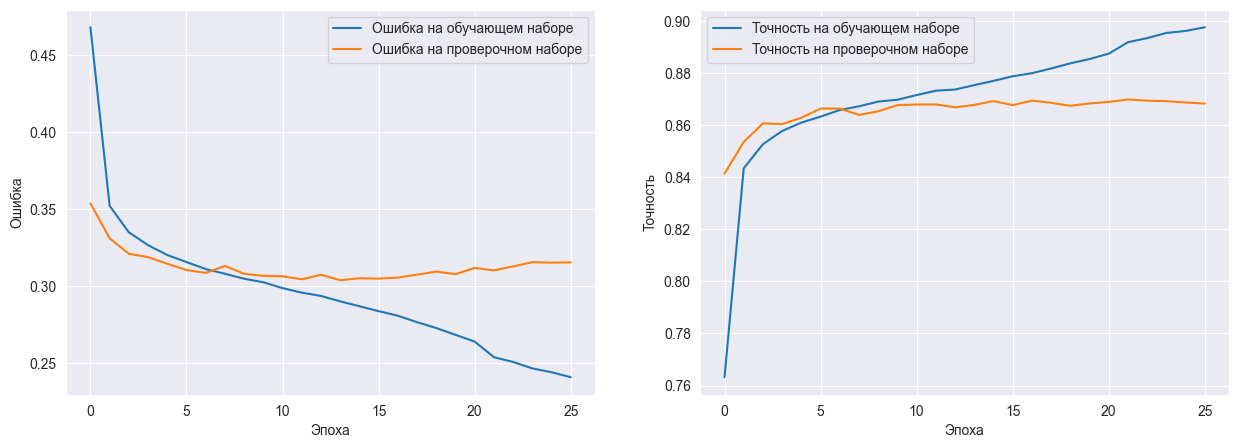

In [4]:
def model_conv1d_best1():
    input = Input(X_train.shape[1])
    x = Reshape((X_train.shape[1],1))(input)

    # Два слоя одномерной свертки Conv1D
    x = Conv1D(30, 3, activation='relu', padding='same')(x)
    x = Conv1D(30, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(60, 3, activation='relu', padding='same')(x)
    x = Conv1D(60, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    # Рекуррентный слой LSTM
    x = LSTM(64, return_sequences=True)(x)

    x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(400, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input,x)

    #model.summary()
    return model

def model_conv1d():
    input = Input(X_train.shape[1])
    x = Reshape((X_train.shape[1],1))(input)

    # Два слоя одномерной свертки Conv1D
    x = Conv1D(30, 3, activation='relu', padding='same')(x)
    x = Conv1D(30, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(60, 3, activation='relu', padding='same')(x)
    x = Conv1D(60, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    # Рекуррентный слой LSTM
    x = Bidirectional(LSTM(64, return_sequences=True))(x)

    x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(400, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input,x)

    #model.summary()
    return model

def model_simple_conv1d():
    input = Input(X_train.shape[1])
    x = Reshape((X_train.shape[1],1))(input)

    # Два слоя одномерной свертки Conv1D
    x = Conv1D(30, 3, activation='relu', padding='same')(x)
    x = Conv1D(30, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)
    x = Conv1D(60, 3, activation='relu', padding='same')(x)
    x = Conv1D(60, 3, activation='relu')(x)
    x = MaxPooling1D(2)(x)

    #x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(400, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input,x)

    #model.summary()
    return model

trainer = train_nn(model_simple_conv1d() , optimizer = Adam(learning_rate = 1e-4))
trainer.fit(X_train,  y_train, X_test, y_test, batch_size = 128, epochs=150)
trainer.plot_history()
trainer.print_stat_report()

# Mazurenko model

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300)]             0         
                                                                 
 flatten_2 (Flatten)         (None, 300)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 4, 300)           0         
 )                                                               
                                                                 
 conv1d_8 (Conv1D)           (None, 4, 256)            384256    
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 2, 256)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 512)               0   

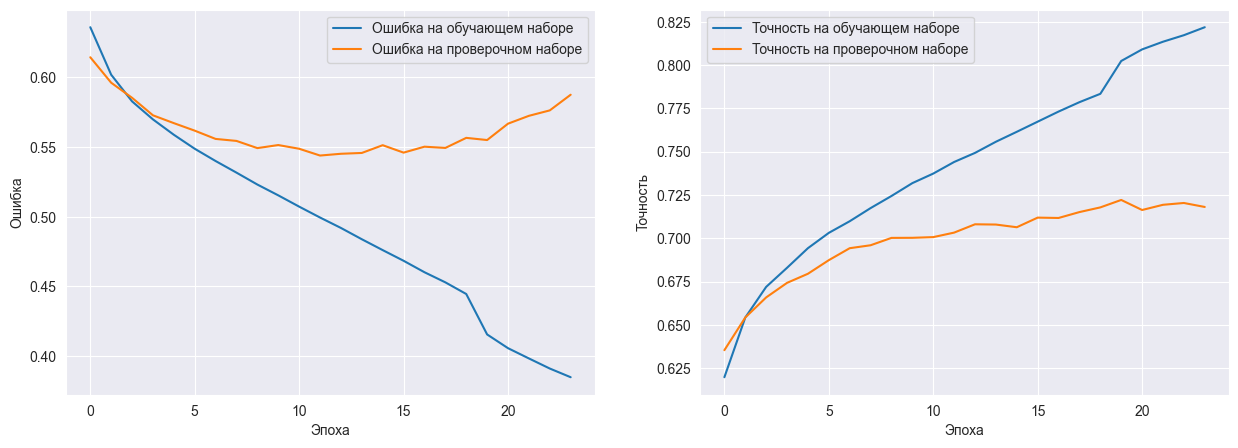

In [9]:
def model_birge():
    input = Input(shape=X_train.shape[1:])
    x = Flatten()(input)
    x = RepeatVector(4)(x)
    x = Conv1D(256, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = RepeatVector(4)(x)
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(2, activation='softmax')(x)

    # Сборка модели из входа и выхода
    model = Model(input, x)
    return model


trainer = train_nn(model_birge() , optimizer = Adam(learning_rate = 1e-4))
trainer.fit(X_train,  y_train, X_test, y_test, batch_size = 128, epochs=150)
trainer.plot_history()
trainer.print_stat_report()

# LSTM1

In [10]:
def modelLSTM1_simple():
    input = Input(X_train.shape[1])

    x = Reshape((X_train.shape[1],1))(input)

    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(input,x)

    #model.summary()
    return model

trainer = train_nn(modelLSTM1_simple() , optimizer = Adam(learning_rate = 1e-4))
trainer.fit(X_train,  y_train, X_test, y_test, batch_size = 128, epochs=150)
trainer.plot_history()
trainer.print_stat_report()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 300)]             0         
                                                                 
 reshape_5 (Reshape)         (None, 300, 1)            0         
                                                                 
 lstm_8 (LSTM)               (None, 300, 64)           16896     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 2)                 130 

KeyboardInterrupt: 

# 2 parts of signal

In [28]:
X_train_1, X_train_2,y_train = nn_data_maker(part_window_of_new_signal = np.linspace(0.15, 0.4, 20), observe_window_lower = 10, observe_window_upper = 300, mooving_average_window_lower = 10, mooving_average_window_upper = 200).make_datas_2_parts_of_signal(150000)
X_test_1, X_test_2,y_test = nn_data_maker(part_window_of_new_signal = np.linspace(0.15, 0.4, 20), observe_window_lower = 10, observe_window_upper = 300, mooving_average_window_lower = 10, mooving_average_window_upper = 200).make_datas_2_parts_of_signal(20000)
print(X_train_1.shape, X_train_2.shape)
print(y_train.shape)
print(X_test_1.shape, X_test_2.shape)
print(y_test.shape)

(150000, 211) (150000, 91)
(150000, 2)
(20000, 211) (20000, 91)
(20000, 2)


# LSTM 1

In [27]:
def model_duble_LSTM_1():
    input1 = tensorflow.keras.layers.Input(X_train_1.shape[1])
    input2 = tensorflow.keras.layers.Input(X_train_2.shape[1])

    x1 = Reshape((X_train_1.shape[1],1))(input1)
    x2 = Reshape((X_train_2.shape[1],1))(input2)

    x1 = LSTM(64, return_sequences=True)(x1)
    x1 = LSTM(64)(x1)

    x2 = LSTM(64, return_sequences=True)(x2)
    x2 = LSTM(64)(x2)

    x = concatenate([x1,x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model([input1,input2],x)

    #model.summary()
    return model


trainer = train_nn(model_duble_LSTM_1() , optimizer = Adam(learning_rate = 5e-4))
trainer.fit([X_train_1, X_train_2],  y_train, [X_test_1, X_test_2], y_test, batch_size = 64, epochs=15)
trainer.plot_history()
trainer.print_stat_report()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 211)]        0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 91)]         0           []                               
                                                                                                  
 reshape_18 (Reshape)           (None, 211, 1)       0           ['input_20[0][0]']               
                                                                                                  
 reshape_19 (Reshape)           (None, 91, 1)        0           ['input_21[0][0]']               
                                                                                           

KeyboardInterrupt: 

# CONV

In [36]:
def model_conv1_2():
    input1 = tensorflow.keras.layers.Input(X_train_1.shape[1])
    input2 = tensorflow.keras.layers.Input(X_train_2.shape[1])
    x1 = Reshape((X_train_1.shape[1],1))(input1)
    x2 = Reshape((X_train_2.shape[1],1))(input2)

    # Два слоя одномерной свертки Conv1D
    x1 = Conv1D(30, 3, activation='relu', padding='same')(x1)
    x1 = Conv1D(30, 3, activation='relu')(x1)
    x1 = MaxPooling1D(2)(x1)
    x1 = LSTM(256)(x1)
    x1 = Flatten()(x1)
    x2 = Conv1D(30, 3, activation='relu', padding='same')(x2)
    x2 = Conv1D(30, 3, activation='relu')(x2)
    x2 = MaxPooling1D(2)(x2)
    x2 = LSTM(256)(x2)
    x2 = Flatten()(x2)
    # Рекуррентный слой LSTM
    #x = LSTM(64, return_sequences=True)(x)
    x = concatenate([x1, x2])
    x = Dropout(0.2)(x)
    #x = BatchNormalization()(x)
    # x = Dense(400, activation='relu')(x)
    # x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model([input1,input2],x)

    #model.summary()
    return model

trainer = train_nn(model_conv1_2() , optimizer = Adam(learning_rate = 5e-4))
trainer.fit([X_train_1, X_train_2],  y_train, [X_test_1, X_test_2], y_test, batch_size = 64, epochs=30)
trainer.plot_history()
trainer.print_stat_report()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 211)]        0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 91)]         0           []                               
                                                                                                  
 reshape_31 (Reshape)           (None, 211, 1)       0           ['input_35[0][0]']               
                                                                                                  
 reshape_32 (Reshape)           (None, 91, 1)        0           ['input_36[0][0]']               
                                                                                           

KeyboardInterrupt: 

# 2 SPECTERS

In [11]:
X_train_1, X_train_2, y_train = nn_data_maker(part_window_of_new_signal = np.linspace(0.15, 0.4, 20), observe_window_lower = 10, observe_window_upper = 300, mooving_average_window_lower = 10, mooving_average_window_upper = 200).make_2_spectr_data(150000, return_one_df=False)
X_test_1 , X_test_2, y_test = nn_data_maker(part_window_of_new_signal = np.linspace(0.15, 0.4, 20), observe_window_lower = 10, observe_window_upper = 300, mooving_average_window_lower = 10, mooving_average_window_upper = 200).make_2_spectr_data(10000, return_one_df=False)
print(X_train_1.shape)
print(y_train.shape)
print(X_test_1.shape)
print(y_test.shape)

(1500, 152)
(150000, 2)
(100, 152)
(10000, 2)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 76)]         0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 128)          9856        ['input_7[0][0]']                
                                                                                                  
 dense_13 (Dense)               (None, 128)          9856        ['input_8[0][0]']                
                                                                                            

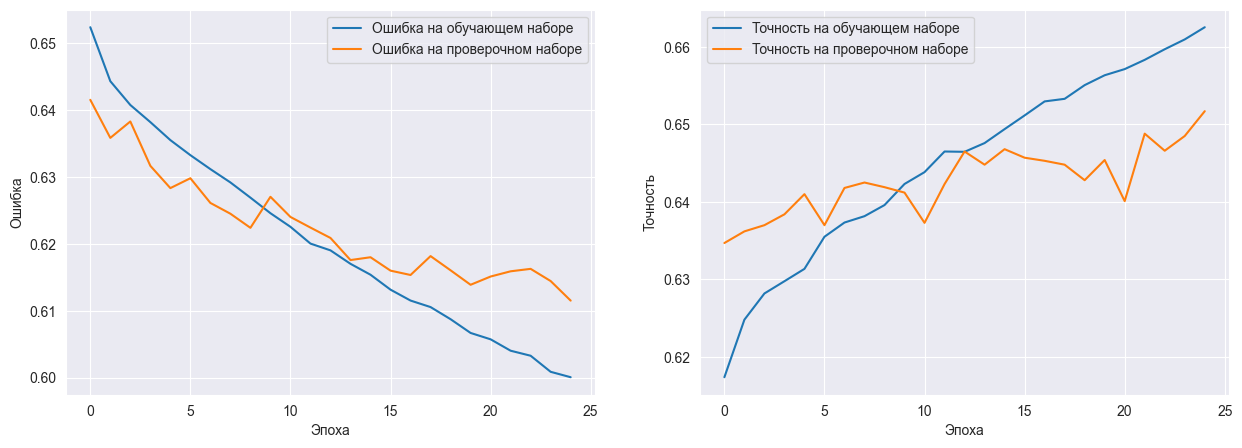

In [14]:
def model_duble_Dense_1():
    input1 = tensorflow.keras.layers.Input(X_train_1.shape[1])
    input2 = tensorflow.keras.layers.Input(X_train_2.shape[1])

    x1 = Dense(128, activation='relu')(input1)
    x2 = Dense(128, activation='relu')(input2)

    x = concatenate([x1,x2])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model([input1,input2],x)

    model.summary()
    return model


trainer = train_nn(model_duble_Dense_1() , optimizer = Adam(learning_rate = 1e-3))
trainer.fit([X_train_1, X_train_2],  y_train, [X_test_1, X_test_2], y_test, batch_size = 64, epochs=25)
trainer.plot_history()
trainer.print_stat_report()

In [15]:
X_train, y_train = nn_data_maker(part_window_of_new_signal = np.linspace(0.15, 0.4, 20), observe_window_lower = 10, observe_window_upper = 300, mooving_average_window_lower = 10, mooving_average_window_upper = 200).make_2_spectr_data(150000)
X_test, y_test = nn_data_maker(part_window_of_new_signal = np.linspace(0.15, 0.4, 20), observe_window_lower = 10, observe_window_upper = 300, mooving_average_window_lower = 10, mooving_average_window_upper = 200).make_2_spectr_data(10000)
print(X_train_1.shape)
print(y_train.shape)
print(X_test_1.shape)
print(y_test.shape)

(150000, 76)
(150000, 2)
(10000, 76)
(10000, 2)


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 152)]             0         
                                                                 
 dense_16 (Dense)            (None, 128)               19584     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 2)                 258       
                                                                 
Total params: 19,842
Trainable params: 19,842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2344/2344 [==============================] - 13s 5ms/step - loss: 0.6541 - accuracy: 0.6146 - val_loss: 0.6476 - val_accuracy: 0.6144 - lr: 0.0010
Epoch 2/25
2344/2344 [=======

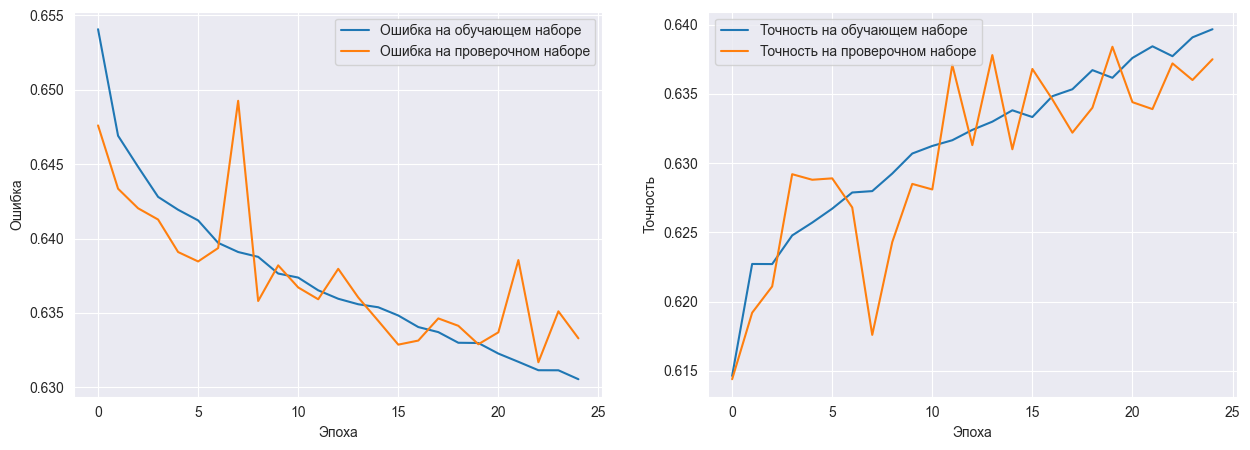

In [16]:
def model_Dense_1():
    input1 = Input(X_train.shape[1])
    l = Dense(128, activation="relu")(input1)
    l = Dropout(0.25)(l)
    #l = BatchNormalization()(l)
    l = Dense(2, activation = 'softmax')(l)
    model = Model(input1, l)
    return model


trainer = train_nn(model_Dense_1() , optimizer = Adam(learning_rate = 1e-3))
trainer.fit(X_train,  y_train, X_test, y_test, batch_size = 64, epochs=25)
trainer.plot_history()
trainer.print_stat_report()